# ResNet18の転移学習
このリンクを押すと[google colab](https://colab.research.google.com/github/yisikawa/PyTorch_TL_ResNet18/blob/main/TL_ResNet18.ipynb)へ移動
### GitHub上のflower_dataをgoogle colab上にコピーして、学習する
##### 注意事項：メニュー「ランタイム」下「ランタイムのタイプを変更」を選び、「ハードウェアアクセラレータ」を「**GPU**」に設定して保存
### flower_dataは以下のフォルダ構成になっている
- flower_data
    - train　学習用
        - daisy
        -dandelion
        -roses
        -sunflowers
        -tulips
    -val　　評価用
        - daisy
        -dandelion
        -roses
        -sunflowers
        -tulips

# flower_dataをGitHubからクローン
#### [GitHub](https://github.com/yisikawa/PyTorch_TL_ResNet18.git)から学習用データをクローンし、確認する

In [ ]:
!git clone https://github.com/yisikawa/PyTorch_TL_ResNet18.git
!ls -l PyTorch_TL_ResNet18

Cloning into 'PyTorch_TL_ResNet18'...
remote: Enumerating objects: 937, done.
remote: Counting objects: 100% (937/937), done.
remote: Compressing objects: 100% (934/934), done.
remote: Total 937 (delta 1), reused 937 (delta 1), pack-reused 0
Receiving objects: 100% (937/937), 43.28 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (1/1), done.
total 196
drwxr-xr-x 4 root root   4096 Apr 28 06:55 flower_data
-rw-r--r-- 1 root root     25 Apr 28 06:55 README.md
-rw-r--r-- 1 root root 189011 Apr 28 06:55 TL_ResNet18.ipynb


# 必要なモジュールをインポートする

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader

#**GPU**の使用を設定する

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

#画像データの前処理
#### サイズ等を変更するなどの前準備を行う

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

#flower_dataを取り込む
#### 学習用と評価用のデータをミニバッチサイズ32でシャフルした形で取り込む設定をする

In [ ]:
train_dataset = datasets.ImageFolder("./PyTorch_TL_ResNet18/flower_data/train",transform=transform)
test_dataset = datasets.ImageFolder("./PyTorch_TL_ResNet18/flower_data/val",transform=transform)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)

#ResNet18のモデルをロードする
#### 学習済みのモデルをロードする

In [ ]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


# モデルを転移学習用に準備する
#### 最終層以外は自動微分を無効(False)に設定し、出力を1000種類から5種類に変更する

In [ ]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512,5)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# GPUを使用して学習をおこなう
- ソフトマックス交差エントロピー損失関数、最適化関数(Adam)を設定
- エポック数(15)分のループ
    - ミニバッチ数(32)分のループ（データはシャッフル）
        - イメージと正解ラベルを取り出す
        - 勾配を初期化
        - 順伝播をおこなう
        - 損失率,正解率を求める
        - 誤差逆伝播を行う
        - 重みを更新する
    - エポックごとの損失率、正解率をプリントする

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 15
losses = []
accs = []
for epochs in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs,labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output,labels)
        running_loss += loss.item()
        pred = torch.argmax(output,dim=1)
        running_acc  += torch.mean(pred.eq(labels).float())
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)
    print("epoch: {}, loss: {}, acc: {}".format(epochs,running_loss,running_acc))


epoch: 0, loss: 1.338868270749631, acc: 0.47644928097724915
epoch: 1, loss: 0.8994658278382343, acc: 0.695652186870575
epoch: 2, loss: 0.6663143220155135, acc: 0.8070652484893799
epoch: 3, loss: 0.5686328994191211, acc: 0.842391312122345
epoch: 4, loss: 0.532485517470733, acc: 0.8564311265945435
epoch: 5, loss: 0.4721508596254432, acc: 0.8509963750839233
epoch: 6, loss: 0.4389597177505493, acc: 0.8645833134651184
epoch: 7, loss: 0.39108492304449494, acc: 0.8913043737411499
epoch: 8, loss: 0.3525767527196718, acc: 0.8890398144721985
epoch: 9, loss: 0.3825645556916361, acc: 0.8854166865348816
epoch: 10, loss: 0.3602391513793365, acc: 0.9021739363670349
epoch: 11, loss: 0.3386873959199242, acc: 0.9021739363670349
epoch: 12, loss: 0.28501861898795416, acc: 0.9293478727340698
epoch: 13, loss: 0.34766437178072723, acc: 0.883152186870575
epoch: 14, loss: 0.3656096445477527, acc: 0.8772645592689514


# 損失率の推移を表示

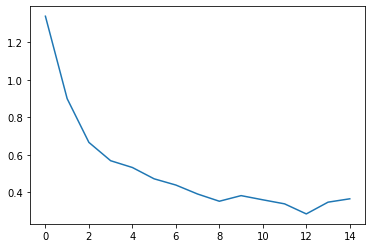

In [ ]:
plt.plot(losses)

# 正解率の推移を表示

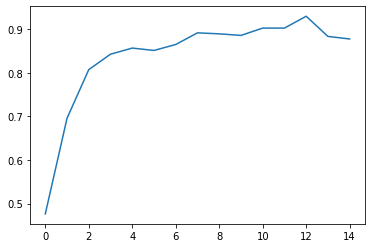

In [ ]:
plt.plot(accs)

#評価用データをランダムに抽出、予測、正解、画像を表示

    予測: rose >>> 正解: rose


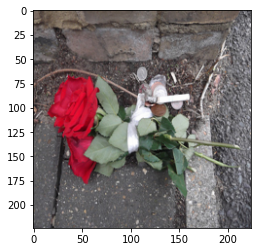

In [ ]:
test_iter = iter(test_loader)
testimgs,testlabels = test_iter.next()
testimg = testimgs[0]
testimg_permute = testimg.permute(1,2,0)
testimg_permute = 0.5*testimg_permute + 0.5
testimg_permute = np.clip(testimg_permute,0,1)
plt.imshow(testimg_permute)
flower_name = ["daisy","dandelion","rose","sunflower","tulip"]
testimgs = testimgs.to(device)
testlabels = testlabels.to(device)
output = model(testimgs)
pred = torch.argmax(output,dim=1)
print("    予測: {} >>> 正解: {}".format(flower_name[pred[0].item()],flower_name[testlabels[0].item()]))